In [1]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
# Load all datasets, two for training and another for testing
# File adapted for starwis dataset
df1 = pd.read_csv('../ready_data/winter_2021.csv')
df2 = pd.read_csv('../ready_data/winter_2022.csv')
train_df = pd.concat([df1, df2])

# Pick a day from 2023 (unseen data)
test_df = pd.read_csv("../ready_data/test_day.csv")

# Necessary renames and other standards for prophet
train_df.rename({"ts": "ds",
           "Friction": "y"}, axis=1, inplace=True, copy=False)
# Make sure that "ds" is in pandas datetime format
train_df["ds"] = pd.to_datetime(train_df["ds"])
# Delete time zone information
train_df['ds'] = train_df['ds'].dt.tz_localize(None)
# After concatenation need to reset index, otherwise end up with duplicated indexes
train_df = train_df.reset_index(drop=True)

test_df.rename({"ts": "ds",
           "Friction": "y"}, axis=1, inplace=True, copy=False)
test_df["ds"] = pd.to_datetime(test_df["ds"])
test_df['ds'] = test_df['ds'].dt.tz_localize(None)

unseen_df = pd.read_csv('../ready_data/winter_2023.csv')
unseen_df.rename({"ts": "ds",
           "Friction": "y"}, axis=1, inplace=True, copy=False)
unseen_df["ds"] = pd.to_datetime(unseen_df["ds"])
unseen_df['ds'] = unseen_df['ds'].dt.tz_localize(None)

In [3]:
# Dict which will be used to make forecast columns
forecasts = {"airTemp": "temp_forecast",
             "humidity": "humidity_forecast",
             "dewpoint": "dewpoint_forecast",
             "precipitation": "precipitation_forecast"
             }

# Create a support columns for both datasets with forecast by shifting data to 6 points back (1 hour)
# Imitates weather forecast from the API and needed to set additional future regressors in model

for key, value in forecasts.items():
    train_df[value] = train_df[key].shift(-12)
# Since last 6 rows can't obtain any information, drop them
train_df = train_df.dropna()

for key, value in forecasts.items():
    test_df[value] = test_df[key].shift(-12)
test_df = test_df.dropna()

for key, value in forecasts.items():
    unseen_df[value] = unseen_df[key].shift(-12)
unseen_df = unseen_df.dropna()

In [4]:
fcst_df = unseen_df[(unseen_df.ds >= "2023-12-12 22:00:00") & (unseen_df.ds < "2023-12-13 00:00:00")]
fcst_df

,ds,airTemp,humidity,dewpoint,precipitation,y,Road_Surface_Temperature,Water_Film_Surface_mm,temp_forecast,humidity_forecast,dewpoint_forecast,precipitation_forecast
6036,2023-12-12 22:00:00,-11.9,85.0,-14.0,4.0,0.486034,-10.898510,0.062336,-11.7,86.0,-13.65,4.0
6037,2023-12-12 22:10:00,-11.8,85.0,-13.9,4.0,0.487912,-10.883616,0.061816,-11.7,86.0,-13.60,4.0
6038,2023-12-12 22:20:00,-11.8,85.0,-13.8,4.0,0.502117,-11.007122,0.058251,-11.6,87.0,-13.50,4.0
6039,2023-12-12 22:30:00,-11.8,86.0,-13.7,4.0,0.499863,-11.044707,0.058813,-11.6,85.0,-13.60,4.0
6040,2023-12-12 22:40:00,-11.8,86.0,-13.7,4.0,0.472643,-11.070496,0.065863,-11.5,86.0,-13.40,4.0
6041,2023-12-12 22:50:00,-11.8,87.0,-13.5,4.0,0.424350,-11.053211,0.079743,-11.5,86.0,-13.40,4.0
6042,2023-12-12 23:00:00,-11.8,88.0,-13.4,4.0,0.400226,-10.995973,0.087472,-11.5,85.0,-13.50,4.0
6043,2023-12-12 23:10:00,-11.7,87.0,-13.5,4.0,0.398024,-10.905258,0.088195,-11.4,86.0,-13.40,4.0
6044,2023-12-12 23:20:00,-11.6,86.0,-13.5,4.0,0.400758,-10.965377,0.087297,-11.4,86.0,-13.30,4.0
6045,2023-12-12 23:30:00,-11.6,86.0,-13.5,4.0,0.407474,-10.789198,0.085077,-11.4,86.0,-13.30,4.0


In [5]:
# Disable logging messages unless there is an error
set_log_level("ERROR")

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds

Training: |          | 0/? [00:00<?, ?it/s]WARNING:tensorflow:From c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\keras\src\losses.py:2976: The name tf.losses.sparse_softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.sparse_softmax_cross_entropy instead.

Epoch 1:   1%|          | 1/100 [00:00<00:00, 1002.46it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 37. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.



Training: |          | 0/? [06:16<?, ?it/s, v_num=12, train_loss=0.0199, reg_loss=0.000, MAE=0.0455, RMSE=0.0697, Loss=0.0199, RegLoss=0.000]


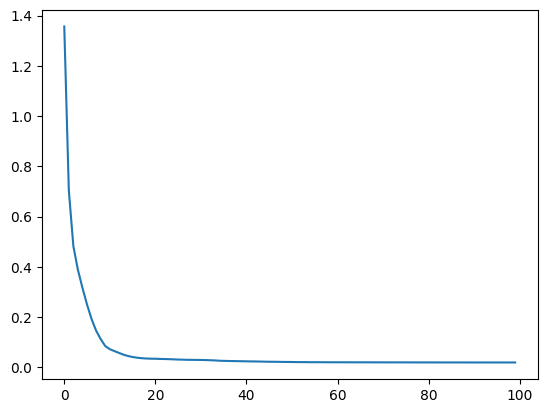

In [6]:
# Lagged regressors are the data from the past
lagged_regressors = ["airTemp", "humidity", "dewpoint",
                     "precipitation", "Water_Film_Surface_mm",
                     "Road_Surface_Temperature"]

m = NeuralProphet(n_changepoints=100,
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=True,
                  changepoints_range=0.95,
                  trend_reg=0.9,
                  growth="off",
                  ar_layers=[32, 16, 8, 4],
                  lagged_reg_layers=[8, 8, 4],
                  future_regressors_model="neural_nets",
                  future_regressors_d_hidden=6,
                  future_regressors_num_hidden_layers=3,
                  learning_rate=0.001,
                  quantiles=[0.2, 0.8],
                  n_forecasts=12,
                  )
n_lags = 36

m.add_lagged_regressor(lagged_regressors, n_lags=n_lags)

# Future regressors are from future, so weather forecast for example
m.add_future_regressor("temp_forecast")
m.add_future_regressor("humidity_forecast")
m.add_future_regressor("dewpoint_forecast")
m.add_future_regressor("precipitation_forecast")

metrics = m.fit(train_df, freq="10min", progress="plot", early_stopping=True, epochs = 100)


In [7]:
future = m.make_future_dataframe(test_df, periods=1, regressors_df=fcst_df, n_historic_predictions=132)

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds

In [8]:
fcst = m.predict(future)
latest_fcst = m.get_latest_forecast(fcst)


WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.14it/s]

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\ne

In [9]:
fcst2 = m.predict(test_df)

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s]


WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\data\process.py:127: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_forecast[name] = yhat

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\ne

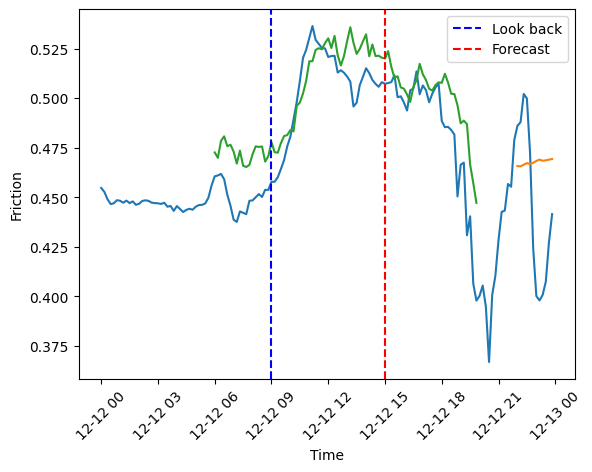

In [10]:
whole_day = unseen_df[(unseen_df.ds >= "2023-12-12 00:00:00") & (unseen_df.ds < "2023-12-13 00:00:00")]

# Plot the data
fig, ax = plt.subplots()
ax.plot(whole_day.ds, whole_day.y)
ax.plot(latest_fcst.ds, latest_fcst["origin-0"])
ax.plot(fcst2.ds, fcst2["yhat1"])
plt.xticks(rotation=45)
# Get the x-tick positions
xticks = ax.get_xticks()

# Add a vertical line at the 3rd x-tick

ax.axvline(x=xticks[3], color='blue', linestyle='--', label=f'Look back')
ax.axvline(x=xticks[5], color='red', linestyle='--', label=f'Forecast')
# Add labels and legend
ax.set_xlabel('Time')
ax.set_ylabel('Friction')
ax.legend()
plt.show()

In [12]:
from neuralprophet import save
save(m, "NeuralProphet.np")

In [15]:
from neuralprophet import load
model = load("NeuralProphet.np")

WARNING - (py.warnings._showwarnmsg) - c:\Users\kiril\Documents\GitHub\ML_project\.venv\Lib\site-packages\neuralprophet\utils.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

Training: |          | 0/? [00:00<?, ?it/s]